In [1]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.contrib.eager as tfe

from scipy.integrate import odeint

keras = tf.keras
tf.enable_eager_execution()

In [2]:
from neuralode_mod import NeuralODE  #this is the package from the github project, reduced to the needed functions

# Oscillator as neural ODE (no control yet)

In [3]:
# oscillator as ODE within Keras
class odeModel_oscillator(tf.keras.Model):

    def __init__(self):
        super(odeModel_oscillator, self).__init__()
        self.A = tf.cast([[0, 1],[-1, -0.1]], tf.float32)

    def call(self, inputs, **kwargs):
        t, y = inputs
        return tf.matmul(y, self.A)

In [4]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5., 5.]], tf.float32)

neural_ode = NeuralODE(odeModel_oscillator(), t=t_grid)
yN, free_trajectory = neural_ode.forward(y0_free, return_states="numpy")

free_trajectory = np.concatenate(free_trajectory)
free_trajectory.shape

(1000, 2)

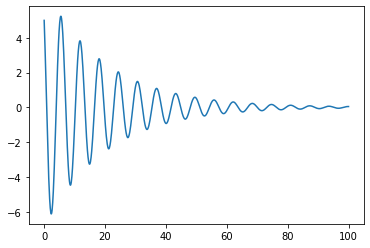

In [5]:
plt.plot(t_grid,free_trajectory[:,0])
plt.show()

# Oscillator with controller

In [6]:
# Oscillator with controller defined by neural network
class odeModel_oscillator_NNcontrol(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_NNcontrol, self).__init__()
        self.linear1 = keras.layers.Dense(50, activation="tanh")
        self.linear2 = keras.layers.Dense(1)
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        
    def call(self, inputs, **kwargs):
        t, y = inputs
        con = self.linear1(y)
        con = self.linear2(con)
        dy = tf.add(tf.matmul(y, self.A), tf.concat([tf.cast([[0.0]],tf.float32),con],1))
        return dy

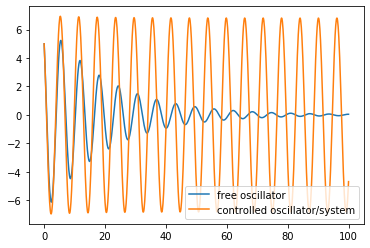

In [7]:
# initialise model
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5., 5.]],tf.float32)

# Run forward evaluation
neural_ode = NeuralODE(odeModel_oscillator_NNcontrol(), t=t_grid)
_, trajectory = neural_ode.forward(y0, return_states="numpy")
trajectory = np.concatenate(trajectory)

# plot
plt.plot(t_grid,free_trajectory[:,0],t_grid, trajectory[:,0])
plt.legend( ('free oscillator', 'controlled oscillator/system'))
plt.show()

### Train

In [8]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 20, time_steps)
y0 = tf.cast([[5., 5.]],tf.float32)
batch_y0=tf.concat([y0,y0],0)

# Free system for comparison
neural_ode = NeuralODE(odeModel_oscillator(), t=t_grid)
yN, free_trajectory = neural_ode.forward(y0_free, return_states="numpy")
free_trajectory = np.concatenate(free_trajectory)

# Initialise new instances of the model
model = odeModel_oscillator_NNcontrol()
neural_ode = NeuralODE(model, t=t_grid)
neural_ode_test = NeuralODE(model, t=t_grid)

In [9]:
# Function for gradient evaluation and update
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)
def compute_gradients_and_update_path(batch_y0):
    with tf.GradientTape() as g:
        
        pred_y, y_points = neural_ode.forward(batch_y0, return_states="tf") # solve ODE forward       
        pred_path = tf.stack(y_points)  # -> (batch_time, batch_size, 3) 
        loss = tf.reduce_mean(tf.math.square(pred_path), axis=1) # -> (batch_time, 2)   
        loss = tf.reduce_mean(loss, axis=0)
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # this makes the code faster

tf.Tensor(113.49295, shape=(), dtype=float32)


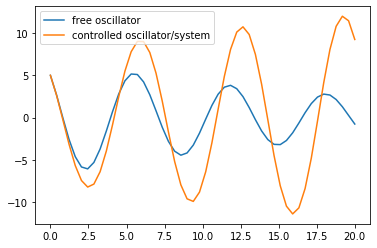

tf.Tensor(21.62844, shape=(), dtype=float32)


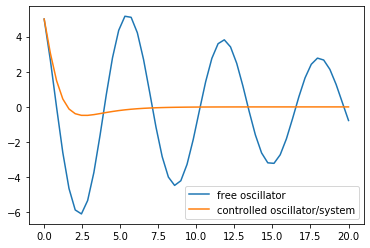

tf.Tensor(16.80122, shape=(), dtype=float32)


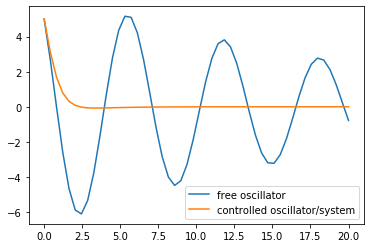

In [10]:
niters = 100
loss_history = []

# Run simulation niters times, updating parameters on each iteration
for step in range(niters+1):
    
    # batch_y0 = y0    # Fixed initial condition
    batch_y0 = tf.random_uniform([1,2], minval=-15.,maxval=15.) # Random
    
    loss = compute_gradients_and_update_path(batch_y0)    
    loss_history.append(loss.numpy())
    
    if step % 50 == 0:        
        yN, states_history_model = neural_ode_test.forward(y0, return_states="numpy")  
        print(loss)
        
        trajectory = np.concatenate(states_history_model)
        plt.plot(t_grid, free_trajectory[:,0], t_grid, trajectory[:,0])
        plt.legend( ('free oscillator', 'controlled oscillator/system'))
        plt.show()

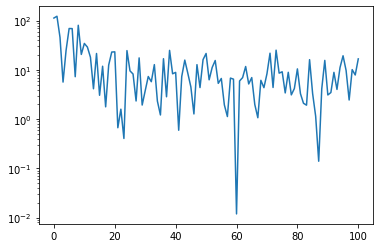

In [11]:
plt.plot(loss_history)
plt.yscale("log")